Calculates A matrix given by

$$[A^{pq}_{ij}] = \iint L_p(\xi) L_q(\eta) L_i(\xi) L_j(\eta) d\xi d\eta$$

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))

import numpy as np
from matplotlib import pyplot as plt
import arrayfire as af

from dg_maxwell import params
from dg_maxwell import utils
from dg_maxwell import lagrange
from dg_maxwell import wave_equation_2d as w2d

af.set_backend(params.backend)

plt.rcParams['figure.figsize']     = 12, 7.5
plt.rcParams['lines.linewidth']    = 1.5
plt.rcParams['font.family']        = 'serif'
plt.rcParams['font.weight']        = 'bold'
plt.rcParams['font.size']          = 20  
plt.rcParams['font.sans-serif']    = 'serif'
plt.rcParams['text.usetex']        = True
plt.rcParams['axes.linewidth']     = 1.5
plt.rcParams['axes.titlesize']     = 'medium'
plt.rcParams['axes.labelsize']     = 'medium'

plt.rcParams['xtick.major.size']   = 8
plt.rcParams['xtick.minor.size']   = 4
plt.rcParams['xtick.major.pad']    = 8
plt.rcParams['xtick.minor.pad']    = 8
plt.rcParams['xtick.color']        = 'k'
plt.rcParams['xtick.labelsize']    = 'medium'
plt.rcParams['xtick.direction']    = 'in'    

plt.rcParams['ytick.major.size']   = 8
plt.rcParams['ytick.minor.size']   = 4
plt.rcParams['ytick.major.pad']    = 8
plt.rcParams['ytick.minor.pad']    = 8
plt.rcParams['ytick.color']        = 'k'
plt.rcParams['ytick.labelsize']    = 'medium'
plt.rcParams['ytick.direction']    = 'in'
plt.rcParams['text.usetex']        = True
plt.rcParams['text.latex.unicode'] = True


In [2]:
# Calculating A matrix using the integrate function
N_LGL   = 4
xi_LGL  = lagrange.LGL_points(N_LGL)
eta_LGL = lagrange.LGL_points(N_LGL)

print(xi_LGL)
_, Lp = lagrange.lagrange_polynomials(xi_LGL)
Lp = af.np_to_af_array(Lp)
Li = Lp.copy()

_, Lq = lagrange.lagrange_polynomials(eta_LGL)
Lq = af.np_to_af_array(Lq)
Lj = Lq.copy()

arrayfire.Array()
Type: double

[4 1 1 1]
   -1.0000 
   -0.4472 
    0.4472 
    1.0000 




In [3]:
Li = af.reorder(Li, d0 = 0, d1 = 2, d2 = 1)
Li = af.transpose(af.tile(Li, d0 = 1, d1 = N_LGL))
Li = af.moddims(Li, d0 = N_LGL * N_LGL, d1 = 1, d2 = N_LGL)
Li = af.transpose(af.tile(Li, d0 = 1, d1 = N_LGL * N_LGL))
Li = af.transpose(af.moddims(af.transpose(Li), d0 = N_LGL * N_LGL * N_LGL * N_LGL, d1 = 1, d2 = N_LGL))
Li = af.reorder(Li, d0 = 2, d1 = 1, d2 = 0)
# print(Li.shape)

Lp = af.reorder(Lp, d0 = 0, d1 = 2, d2 = 1)
Lp = af.transpose(af.tile(Lp, d0 = 1, d1 = N_LGL))
Lp = af.moddims(Lp, d0 = N_LGL * N_LGL, d1 = 1, d2 = N_LGL)
Lp = af.tile(Lp, d0 = 1, d1 = N_LGL * N_LGL)
Lp = af.moddims(af.transpose(Lp), d0 = N_LGL * N_LGL * N_LGL * N_LGL, d1 = 1, d2 = N_LGL)
Lp = af.reorder(af.transpose(Lp), d0 = 2, d1 = 1, d2 = 0)
# print(af.transpose(bar))

Lp_Li = af.transpose(af.convolve1(Li, Lp, conv_mode = af.CONV_MODE.EXPAND))
print(Lp_Li.shape)

(256, 7)


In [4]:
Lj = af.reorder(Lj, d0 = 0, d1 = 2, d2 = 1)
Lj = af.tile(Lj, d0 = 1, d1 = N_LGL)
Lj = af.moddims(Lj, d0 = N_LGL * N_LGL, d1 = 1, d2 = N_LGL)
Lj = af.transpose(af.tile(Lj, d0 = 1, d1 = N_LGL * N_LGL))
Lj = af.moddims(af.transpose(Lj), d0 = N_LGL * N_LGL * N_LGL * N_LGL, d1 = 1, d2 = N_LGL)
Lj = af.reorder(Lj, d0 = 2, d1 = 0, d2 = 1)
# print(foo.shape)

Lq = af.reorder(Lq, d0 = 0, d1 = 2, d2 = 1)
Lq = af.tile(Lq, d0 = 1, d1 = N_LGL)
Lq = af.moddims(Lq, d0 = N_LGL * N_LGL, d1 = 1, d2 = N_LGL)
Lq = af.tile(Lq, d0 = 1, d1 = N_LGL * N_LGL)
Lq = af.moddims(af.transpose(Lq), d0 = N_LGL * N_LGL * N_LGL * N_LGL, d1 = 1, d2 = N_LGL)
Lq = af.reorder(af.transpose(Lq), d0 = 2, d1 = 1, d2 = 0)
# print(bar)

Lq_Lj = af.transpose(af.convolve1(Lj, Lq, conv_mode = af.CONV_MODE.EXPAND))
print(Lq_Lj.shape)

(256, 7)


In [12]:
A = af.moddims(utils.integrate_2d(Lp_Li, Lq_Lj, order = 9, scheme = 'gauss'), d0 = N_LGL * N_LGL, d1 = N_LGL * N_LGL)

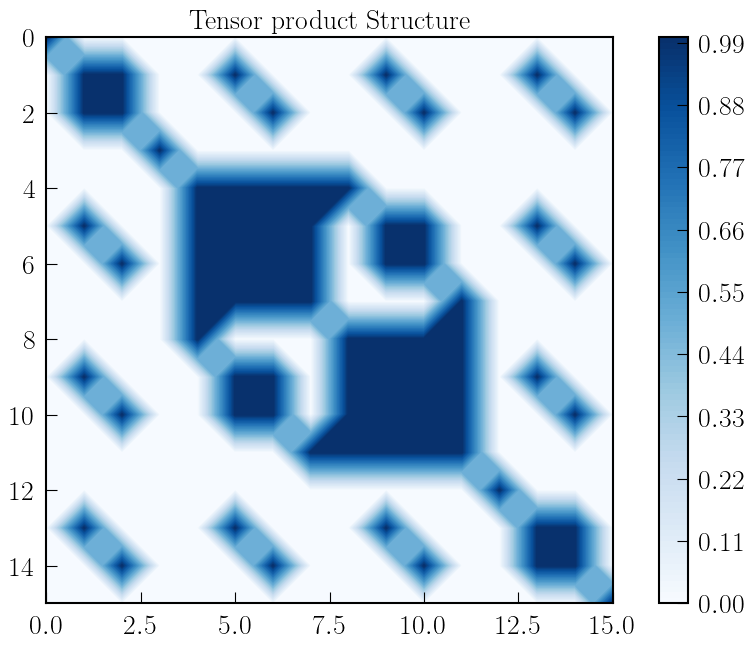

In [13]:
#plot the matrix structure for the matrices.

A_matrix_structure = np.zeros((A.shape[0], A.shape[1]))
threshold = 1e-2
non_zero_indices = np.where(af.abs(A) > threshold)
A_matrix_structure[non_zero_indices] = 1.

plt.gca().invert_yaxis()
plt.contourf(A_matrix_structure, 100, cmap = 'Blues')
plt.axes().set_aspect('equal')
plt.colorbar()
plt.title('Tensor product Structure')
plt.savefig('tensor_product_structure.png')
plt.show()

In [ ]:
0.0204081632653059
0.00760567339285643
-0.00760567339285637
0.00340136054421767
0.00760567339285635
0.00283446712018141
-0.00283446712018138
0.00126761223214273
-0.00760567339285636
-0.00283446712018142
0.00283446712018139
-0.00126761223214273
0.00340136054421766
0.00126761223214275
-0.00126761223214273
0.000566893424036280


In [3]:
A_ref = af.np_to_af_array(np.array([[0.0204081632653059, #pq = 00
                                     0.00760567339285643,
                                     -0.00760567339285637,
                                     0.00340136054421767,
                                     0.00760567339285635,
                                     0.00283446712018141,
                                     -0.00283446712018138,
                                     0.00126761223214273,
                                     -0.00760567339285636,
                                     -0.00283446712018142,
                                     0.00283446712018139,
                                     -0.00126761223214273,
                                     0.00340136054421766,
                                     0.00126761223214275,
                                     -0.00126761223214273,
                                     0.000566893424036280],
                                   [0.00760567339285643, # pq = 01
                                    0.102040816326530,
                                    0.0170068027210882,
                                    -0.00760567339285634,
                                    0.00283446712018141,
                                    0.0380283669642819,
                                    0.00633806116071359,
                                    -0.00283446712018138,
                                    -0.00283446712018142,
                                    -0.0380283669642820,
                                    -0.00633806116071361,
                                    0.00283446712018138,
                                    0.00126761223214275,
                                    0.0170068027210884,
                                    0.00283446712018138,
                                    -0.00126761223214273],
                                   [-0.00760567339285637, # pq = 02
                                    0.0170068027210882,
                                    0.102040816326530,
                                    0.00760567339285636,
                                    -0.00283446712018138,
                                    0.00633806116071359,
                                    0.0380283669642819,
                                    0.00283446712018138,
                                    0.00283446712018139,
                                    -0.00633806116071361,
                                    -0.0380283669642820,
                                    -0.00283446712018139,
                                    -0.00126761223214273,
                                    0.00283446712018138,
                                    0.0170068027210884,
                                    0.00126761223214273],
                                   [0.00340136054421767, # pq = 03
                                    -0.00760567339285634,
                                    0.00760567339285636,
                                    0.0204081632653059,
                                    0.00126761223214273,
                                    -0.00283446712018138,
                                    0.00283446712018138,
                                    0.00760567339285635,
                                    -0.00126761223214273,
                                    0.00283446712018138,
                                    -0.00283446712018139,
                                    -0.00760567339285636,
                                    0.000566893424036280,
                                    -0.00126761223214273,
                                    0.00126761223214273,
                                    0.00340136054421766],
                                   [0.00760567339285635, # pq = 10
                                    0.00283446712018141,
                                    -0.00283446712018138,
                                    0.00126761223214273,
                                    0.102040816326530,
                                    0.0380283669642819,
                                    -0.0380283669642820,
                                    0.0170068027210884,
                                    0.0170068027210882,
                                    0.00633806116071365,
                                    -0.00633806116071360,
                                    0.00283446712018137,
                                    -0.00760567339285636,
                                    -0.00283446712018142,
                                    0.00283446712018139,
                                    -0.00126761223214273],
                                   [0.00283446712018141, # pq = 11
                                    0.0380283669642819,
                                    0.00633806116071359,
                                    -0.00283446712018138,
                                    0.0380283669642819,
                                    0.510204081632653,
                                    0.0850340136054413,
                                    -0.0380283669642820,
                                    0.00633806116071365,
                                    0.0850340136054412,
                                    0.0141723356009067,
                                    -0.00633806116071359,
                                    -0.00283446712018142,
                                    -0.0380283669642820,
                                    -0.00633806116071361,
                                    0.00283446712018138],
                                   [-0.00283446712018138, # pq = 12
                                    0.00633806116071359,
                                    0.0380283669642819,
                                    0.00283446712018138,
                                    -0.0380283669642820,
                                    0.0850340136054413,
                                    0.510204081632653,
                                    0.0380283669642819,
                                    -0.00633806116071360,
                                    0.0141723356009067,
                                    0.0850340136054412,
                                    0.00633806116071359,
                                    0.00283446712018139,
                                    -0.00633806116071361,
                                    -0.0380283669642820,
                                    -0.00283446712018139],
                                   [0.00126761223214273, # pq = 13
                                    -0.00283446712018138,
                                    0.00283446712018138,
                                    0.00760567339285635,
                                    0.0170068027210884,
                                    -0.0380283669642820,
                                    0.0380283669642819,
                                    0.102040816326530,
                                    0.00283446712018137,
                                    -0.00633806116071359,
                                    0.00633806116071359,
                                    0.0170068027210882,
                                    -0.00126761223214273,
                                    0.00283446712018138,
                                    -0.00283446712018139,
                                    -0.00760567339285636],
                                   [-0.00760567339285636, # pq = 20
                                    -0.00283446712018142,
                                    0.00283446712018139,
                                    -0.00126761223214273,
                                    0.0170068027210882,
                                    0.00633806116071365,
                                    -0.00633806116071360,
                                    0.00283446712018137,
                                    0.102040816326530,
                                    0.0380283669642819,
                                    -0.0380283669642820,
                                    0.0170068027210884,
                                    0.00760567339285635,
                                    0.00283446712018141,
                                    -0.00283446712018138,
                                    0.00126761223214273],
                                   [-0.00283446712018142, # pq = 21
                                    -0.0380283669642820,
                                    -0.00633806116071361,
                                    0.00283446712018138,
                                    0.00633806116071365,
                                    0.0850340136054412,
                                    0.0141723356009067,
                                    -0.00633806116071359,
                                    0.0380283669642819,
                                    0.510204081632653,
                                    0.0850340136054413,
                                    -0.0380283669642820,
                                    0.00283446712018141,
                                    0.0380283669642819,
                                    0.00633806116071359,
                                    -0.00283446712018138],
                                   [0.00283446712018139, # pq = 22
                                    -0.00633806116071361,
                                    -0.0380283669642820,
                                    -0.00283446712018139,
                                    -0.00633806116071360,
                                    0.0141723356009067,
                                    0.0850340136054412,
                                    0.00633806116071359,
                                    -0.0380283669642820,
                                    0.0850340136054413,
                                    0.510204081632653,
                                    0.0380283669642819,
                                    -0.00283446712018138,
                                    0.00633806116071359,
                                    0.0380283669642819,
                                    0.00283446712018138],
                                   [-0.00126761223214273, # pq = 23
                                    0.00283446712018138,
                                    -0.00283446712018139,
                                    -0.00760567339285636,
                                    0.00283446712018137,
                                    -0.00633806116071359,
                                    0.00633806116071359,
                                    0.0170068027210882,
                                    0.0170068027210884,
                                    -0.0380283669642820,
                                    0.0380283669642819,
                                    0.102040816326530,
                                    0.00126761223214273,
                                    -0.00283446712018138,
                                    0.00283446712018138,
                                    0.00760567339285635],
                                   [0.00340136054421766, # pq = 30
                                    0.00126761223214275,
                                    -0.00126761223214273,
                                    0.000566893424036280,
                                    -0.00760567339285636,
                                    -0.00283446712018142,
                                    0.00283446712018139,
                                    -0.00126761223214273,
                                    0.00760567339285635,
                                    0.00283446712018141,
                                    -0.00283446712018138,
                                    0.00126761223214273,
                                    0.0204081632653059,
                                    0.00760567339285643,
                                    -0.00760567339285637,
                                    0.00340136054421767],
                                   [0.00126761223214275, # pq = 31
                                    0.0170068027210884,
                                    0.00283446712018138,
                                    -0.00126761223214273,
                                    -0.00283446712018142,
                                    -0.0380283669642820,
                                    -0.00633806116071361,
                                    0.00283446712018138,
                                    0.00283446712018141,
                                    0.0380283669642819,
                                    0.00633806116071359,
                                    -0.00283446712018138,
                                    0.00760567339285643,
                                    0.102040816326530,
                                    0.0170068027210882,
                                    -0.00760567339285634],
                                   [-0.00126761223214273, # pq = 32
                                    0.00283446712018138,
                                    0.0170068027210884,
                                    0.00126761223214273,
                                    0.00283446712018139,
                                    -0.00633806116071361,
                                    -0.0380283669642820,
                                    -0.00283446712018139,
                                    -0.00283446712018138,
                                    0.00633806116071359,
                                    0.0380283669642819,
                                    0.00283446712018138,
                                    -0.00760567339285637,
                                    0.0170068027210882,
                                    0.102040816326530,
                                    0.00760567339285636],
                                   [0.000566893424036280, # pq = 33
                                    -0.00126761223214273,
                                    0.00126761223214273,
                                    0.00340136054421766,
                                    -0.00126761223214273,
                                    0.00283446712018138,
                                    -0.00283446712018139,
                                    -0.00760567339285636,
                                    0.00126761223214273,
                                    -0.00283446712018138,
                                    0.00283446712018138,
                                    0.00760567339285635,
                                    0.00340136054421767,
                                    -0.00760567339285634,
                                    0.00760567339285636,
                                    0.0204081632653059]]))

A_ref_np = np.array(A_ref)
np.savetxt('A_matrix_ref.csv', A_ref_np, delimiter = ',')

In [15]:
print(np.abs(np.array(A[0]) - np.array(A_ref[0])) < 1e-5)
print(np.abs(np.array(A[1]) - np.array(A_ref[1])) < 1e-5)
print(np.abs(np.array(A[2]) - np.array(A_ref[2])) < 1e-5)
print(np.abs(np.array(A[3]) - np.array(A_ref[3])) < 1e-5)
print(np.abs(np.array(A[4]) - np.array(A_ref[4])) < 1e-5)
print(np.abs(np.array(A[5]) - np.array(A_ref[5])) < 1e-4)
print(np.abs(np.array(A[6]) - np.array(A_ref[6])) < 1e-4)
print(np.abs(np.array(A[7]) - np.array(A_ref[7])) < 1e-5)
print(np.abs(np.array(A[8]) - np.array(A_ref[8])) < 1e-5)
print(np.abs(np.array(A[9]) - np.array(A_ref[9])) < 1e-4)
print(np.abs(np.array(A[10]) - np.array(A_ref[10])) < 1e-4)
print(np.abs(np.array(A[11]) - np.array(A_ref[11])) < 1e-5)
print(np.abs(np.array(A[12]) - np.array(A_ref[12])) < 1e-5)
print(np.abs(np.array(A[13]) - np.array(A_ref[13])) < 1e-5)
print(np.abs(np.array(A[14]) - np.array(A_ref[14])) < 1e-5)
print(np.abs(np.array(A[15]) - np.array(A_ref[15])) < 1e-5)

[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]]
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]]
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]]
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]]
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]]
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]]
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]]
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]]
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]]
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True 

In [14]:
af.all_true(af.abs(A - A_ref) < 1e-4)

1.0

In [2]:
# A matrix from the wave_equation_2d module
A = w2d.A_matrix()

In [7]:
af.display(A[7, 0], 14)